In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

import torch
print(f'CUDA available is {torch.cuda.is_available()}')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.metrics.pairwise import cosine_similarity
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

from scipy.optimize import curve_fit

CUDA available is False


# Load Data

In [2]:
df_genes = pd.read_parquet('/lisc/user/gaehtgens/data/TMS/output')
# somehow there are duplicates! I think the script to generate the data is wrong
df_genes = df_genes.loc[~df_genes.index.duplicated(keep='first')].drop_duplicates()

# EDA - Genes

### Gene Cosine Similarity

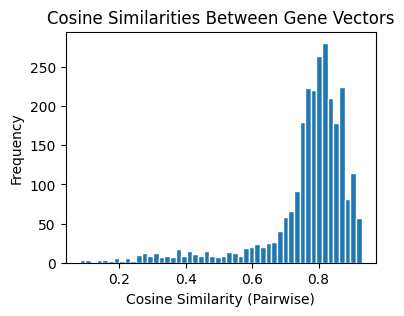

In [3]:
df_genes_tensor = torch.tensor(df_genes.values, dtype=torch.float32, device=device)
genes_centroid = df_genes_tensor.mean(dim=0, keepdim=True)
cos_sim_genes = torch.nn.functional.cosine_similarity(df_genes_tensor, genes_centroid, dim=1)

plt.figure(figsize=(4, 3))
plt.hist(cos_sim_genes.cpu().numpy(), 
         bins=50, 
         edgecolor='white')
plt.title('Cosine Similarities Between Gene Vectors')
plt.ylabel('Frequency')
plt.xlabel('Cosine Similarity (Pairwise)')
plt.show()

### Sparsity

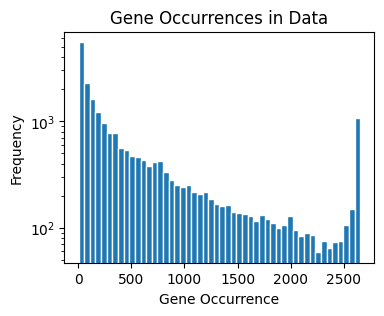

In [4]:
# We saw that the genes that happen more often are usually the ones with highest coverage
plt.figure(figsize=(4, 3))
plt.hist((df_genes>0).sum(0).values, 
         bins=50, 
         edgecolor='white')
plt.title('Gene Occurrences in Data')
plt.ylabel('Frequency')
plt.xlabel('Gene Occurrence')
plt.yscale('log')
plt.show()

### Gene Mean Coverage Distribution

In [5]:
df_genes.mean(1)

DRR003635     1.797176
DRR003644     2.100202
DRR014176     5.847559
DRR042312     2.147326
DRR070915     6.495173
                ...   
SRR9865754    1.430536
SRR9879728    3.142906
SRR9879766    6.517694
SRR9879770    1.993665
SRR9988195    0.547864
Length: 2658, dtype: float32

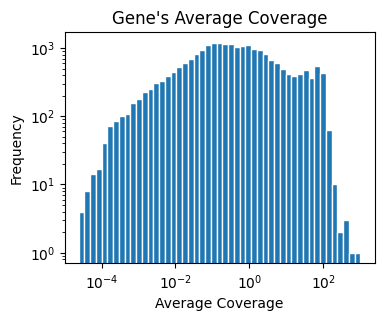

In [6]:
cvg_means = df_genes.mean(0)
bins = np.logspace(np.log10(cvg_means.min()), np.log10(cvg_means.max()), 50)

plt.figure(figsize=(4, 3))
plt.hist(df_genes.mean(0), 
         bins=bins, 
         edgecolor='white')
plt.title("Gene's Average Coverage")
plt.ylabel('Frequency')
plt.xlabel('Average Coverage')
plt.yscale('log')
plt.xscale('log')
plt.show()

# Gene vs. Species Similarity

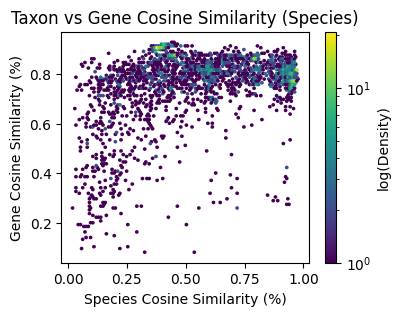

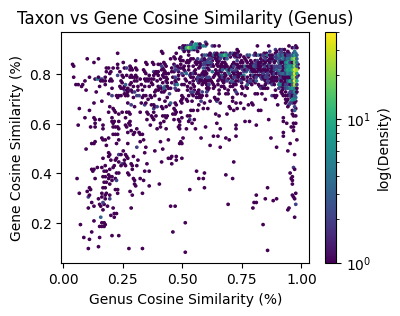

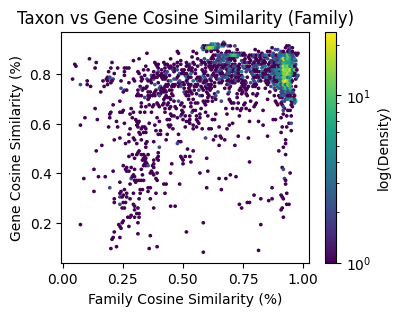

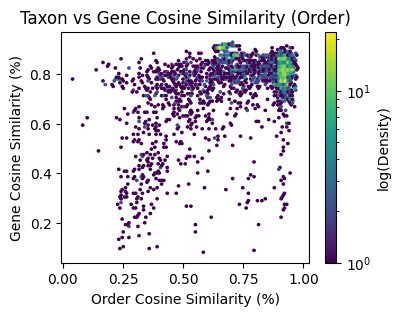

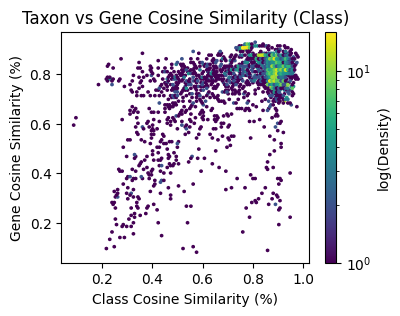

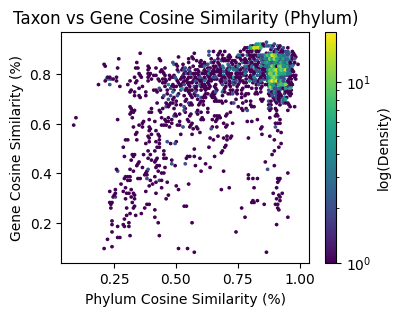

In [7]:
# Taxon levels and their display names
taxons = ["s", "g", "f", "o", "c", "p"]  # species, genus, family, order, class, phylum
taxon_name = {
    "s": "Species",
    "g": "Genus",
    "f": "Family",
    "o": "Order",
    "c": "Class",
    "p": "Phylum"
}

# Loop through each taxon level and process
for tx in taxons:
    
    # Read the taxon coverage DataFrame for the current taxon level
    df_taxon = pd.read_parquet(f"../processed_data/taxon_coverage_{tx}.parquet")
    if "Sample" in df_taxon.columns:
        df_taxon = df_taxon.set_index("Sample")

    # Make sure the indexes match and order is the same
    df_taxon = df_taxon.reindex(df_genes.index).dropna(axis=0, how="any")  # Drop any rows with NaN

    # Compute cosine similarity for gene data (you already have this)
    genes_centroid = df_genes_tensor.mean(dim=0, keepdim=True)
    cos_sim_genes = torch.nn.functional.cosine_similarity(df_genes_tensor, genes_centroid, dim=1)

    # Compute cosine similarity for taxon data
    df_taxon_tensor = torch.tensor(df_taxon.values, dtype=torch.float32, device=device)
    taxon_centroid = df_taxon_tensor.mean(dim=0, keepdim=True)
    cos_sim_taxon = torch.nn.functional.cosine_similarity(df_taxon_tensor, taxon_centroid, dim=1)

    # Create hexbin plot
    plt.figure(figsize=(4, 3))
    plt.hexbin(cos_sim_taxon.cpu().numpy(), cos_sim_genes.cpu().numpy(), gridsize=100, cmap="viridis", bins="log")
    plt.colorbar(label="log(Density)")
    plt.xlabel(f"{taxon_name[tx]} Cosine Similarity (%)")
    plt.ylabel("Gene Cosine Similarity (%)")
    plt.title(f"Taxon vs Gene Cosine Similarity ({taxon_name[tx]})")
    plt.show()

# Multiple Logistic Regressions

In [8]:
# Create an empty list to hold the dataframes
df_taxons = []

# Loop through each taxon level and read the corresponding data
for tx in taxons:
    df_taxon = pd.read_parquet(f"../processed_data/taxon_coverage_{tx}.parquet")
    if "Sample" in df_taxon.columns:
        df_taxon = df_taxon.set_index("Sample")
    
    # Reindex to match df_genes and drop rows with NaN
    df_taxon = df_taxon.reindex(df_genes.index).dropna(axis=0, how="any")
    
    # Add the dataframe to the list
    df_taxons.append(df_taxon)

# Merge all taxon dataframes on the index
df_merged_taxons = pd.concat(df_taxons, axis=1)

In [9]:
df_merged_taxons

,Bifidobacterium longum,Bifidobacterium infantis,Bifidobacterium breve,Bifidobacterium bifidum,Collinsella sp022728415,Bacteroides fragilis,Bacteroides stercoris,Bacteroides caccae,Phocaeicola vulgatus,Prevotella sp900543975,...,Caldisericota,UBA10199,Desulfobacterota_B,Myxococcota_A,KSB1,Cloacimonadota,Hydrogenedentota,Desulfobacterota_G,Riflebacteria,Desulfobacterota_D
DRR003635,130.81,16.70,50.19,0.00,0.0,0.00,12.69,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DRR003644,78.18,74.12,32.06,0.00,0.0,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DRR014176,139.44,20.00,1.20,0.00,0.0,0.00,0.00,7.14,0.69,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DRR042312,153.12,13.90,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DRR070915,315.74,32.24,15.39,0.00,0.0,37.44,25.56,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR9865754,44.52,101.94,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR9879728,124.73,17.22,0.00,33.87,0.0,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR9879766,72.79,388.49,1.79,0.69,0.0,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR9879770,95.93,17.89,40.23,0.00,0.0,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Pre-Processing

In [10]:
# Remove taxon and genes that show up less than threshold times
threshold = 200

gene_occurrences = (df_genes > 0).sum(0)
taxon_occurrences = (df_merged_taxons > 0).sum(0)

print(f"Removing {df_genes.shape[1] - (gene_occurrences >= threshold).sum()} genes.")
print(f"Removing {df_merged_taxons.shape[1] - (taxon_occurrences >= threshold).sum()} taxon levels.")

df_genes = df_genes.loc[:, gene_occurrences >= threshold]
df_merged_taxons = df_merged_taxons.loc[:, taxon_occurrences >= threshold]

Removing 10360 genes.
Removing 6946 taxon levels.


In [11]:
df_genes

,MGYG000004913#00001-CDS=1-1323,MGYG000004913#00004-CDS=1-1011,MGYG000004913#00033-CDS=1-771,MGYG000004913#00048-CDS=1-1017,MGYG000004913#00058-CDS=1-798,MGYG000004913#00065-CDS=1-1002,MGYG000004913#00070-CDS=1-894,MGYG000004913#00082-CDS=1-1074,MGYG000004913#00088-CDS=1-1593,MGYG000004913#00095-CDS=1-1347,...,MGYG000288786#00930-CDS=1-708,MGYG000288786#01146-CDS=1-759,MGYG000288786#01789-CDS=1-429,MGYG000288786#01880-CDS=1-1731,MGYG000288955#00763-CDS=1-666,MGYG000288955#01246-CDS=1-3333,MGYG000288955#02198-CDS=1-573,MGYG000289105#00065-CDS=1-1008,MGYG000289105#00704-CDS=1-555,MGYG000289360#00741-CDS=1-321
DRR003635,22.499077,17.217203,23.441853,12.469826,18.433905,14.865144,17.707010,14.024598,16.470316,17.375404,...,0.000000,0.000000,0.000000,0.133333,0.181682,0.000000,0.000000,15.065412,1.068468,0.000000
DRR003644,23.229347,11.137668,15.121297,13.757538,17.503717,15.948910,25.919683,19.427071,15.174053,13.943593,...,0.000000,0.000000,0.000000,5.986727,0.523380,0.000000,0.205934,7.397830,0.000000,0.358255
DRR014176,61.800232,55.369698,83.939590,48.472172,74.171936,59.572395,50.165894,97.396271,52.534546,52.442848,...,0.000000,0.108037,0.000000,0.046406,0.297568,0.173330,0.305410,34.993950,0.000000,0.000000
DRR042312,42.777122,24.257545,32.929909,34.144451,29.164967,40.454586,24.572393,77.866737,39.656475,33.986336,...,1.805146,0.375494,0.000000,0.000000,0.000000,0.000000,2.443281,8.940099,0.000000,0.000000
DRR070915,78.493431,89.902664,72.953049,60.542095,73.057541,79.157410,77.484612,112.221992,82.382233,91.852791,...,0.000000,0.454545,0.328671,0.078161,0.210300,2.731188,4.046248,50.803841,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR9865754,16.275133,18.294790,6.029072,8.277387,10.627193,13.651952,12.844213,25.358236,19.540113,8.334942,...,0.000000,0.000000,0.000000,12.905588,0.000000,0.000000,1.848168,0.000000,0.000000,0.719626
SRR9879728,27.975929,32.952347,29.578562,40.652035,30.949654,32.290749,27.944906,77.216461,28.781519,40.213116,...,0.000000,0.000000,0.424242,0.000000,1.011832,0.000000,0.000000,17.445263,0.000000,0.000000
SRR9879766,83.824432,73.410049,62.426689,93.754753,81.753555,87.009064,41.629490,133.860962,95.974892,90.225578,...,10.444527,0.000000,0.000000,36.532249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SRR9879770,27.141848,22.684530,22.248619,23.530886,18.729595,23.958044,25.228436,47.883926,26.460989,27.979307,...,0.000000,0.000000,0.272727,0.045402,0.000000,0.970068,0.080279,12.682604,0.000000,0.000000
